In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import keras.models
import tensorflow

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading the Images
X = []
Y = []

for i in tqdm(glob('/kaggle/input/mrl-eye-dataset/data/train/open eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(1)
    
for i in tqdm(glob('/kaggle/input/mrl-eye-dataset/data/train/close eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(0)

100%|██████████| 40380/40380 [04:58<00:00, 135.25it/s]


In [3]:
# Normalizing the images using Min-Max Scaling algorithm
X = (np.array(X) - np.min(X)) / (np.max(X) - np.min(X))
X = X/255.0
Y = (np.array(Y) - np.min(Y)) / (np.max(Y) - np.min(Y))

# Expanding the dimensions of array (numpy
X = np.expand_dims(X,-1)

In [4]:
# Spliting the dataset into training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [5]:
# CNN Model
from keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten

model = tf.keras.models.Sequential([
    Input(shape=(64, 64, 1)),
    
    Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(units=256, activation='relu'),
    BatchNormalization(),
    Dense(units=128, activation='relu'),
    Dense(units=1, activation='sigmoid')
])


# Compiling the Model
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [6]:
# Training of the Model
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/HighAccModel.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    
    verbose =1)
# model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=callback)
history = model.fit(x_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[callback])

Epoch 1/100
1369/1369 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9491
Epoch 1: val_loss improved from inf to 0.21792, saving model to /kaggle/working/HighAccModel.h5
1369/1369 [==============================] - 38s 14ms/step - loss: 0.1330 - accuracy: 0.9491 - val_loss: 0.2179 - val_accuracy: 0.9003
Epoch 2/100
1367/1369 [============================>.] - ETA: 0s - loss: 0.0587 - accuracy: 0.9780
Epoch 2: val_loss improved from 0.21792 to 0.08929, saving model to /kaggle/working/HighAccModel.h5
1369/1369 [==============================] - 18s 13ms/step - loss: 0.0587 - accuracy: 0.9780 - val_loss: 0.0893 - val_accuracy: 0.9681
Epoch 3/100
1369/1369 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9821
Epoch 3: val_loss did not improve from 0.08929
1369/1369 [==============================] - 18s 13ms/step - loss: 0.0501 - accuracy: 0.9821 - val_loss: 0.2277 - val_accuracy: 0.9307
Epoch 4/100
1365/1369 [============================>.] 

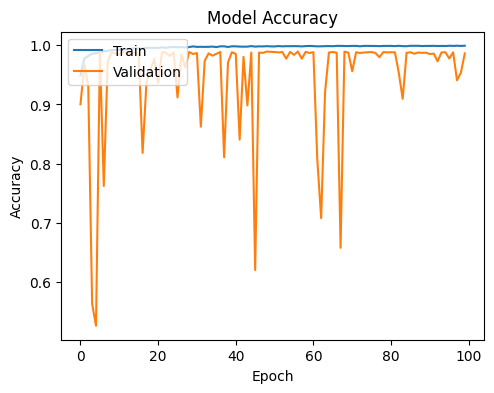

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

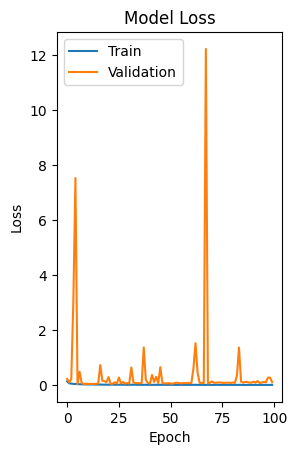

In [8]:
# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 21ms/step
Accuracy: 0.9838659633881477


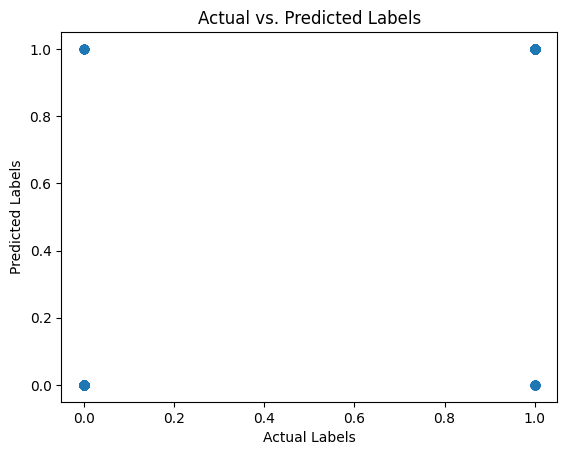

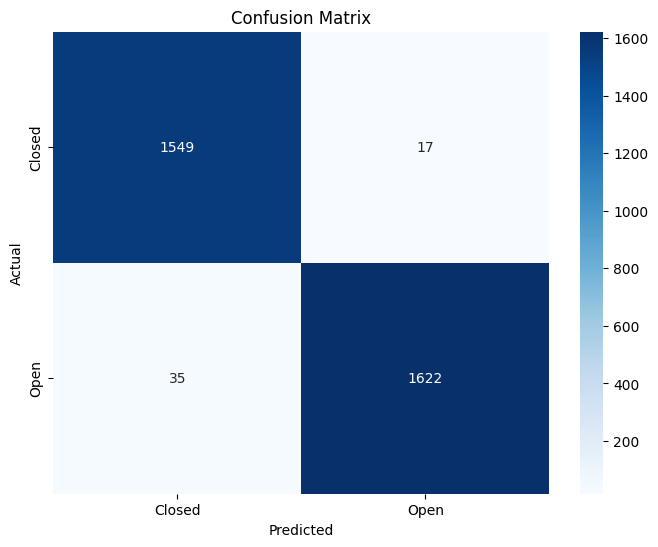

In [10]:
from keras.models import load_model
import cv2
import numpy as np
import os
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the best model
best_model = load_model('/kaggle/working/HighAccModel.h5')

# Create lists to store actual and predicted labels
actual_labels = []
predicted_labels = []

# Define paths to the "open eyes" and "close eyes" folders
open_eyes_path = '/kaggle/input/mrl-eye-dataset/data/test/open eyes'
close_eyes_path = '/kaggle/input/mrl-eye-dataset/data/test/close eyes'

# Loop through "open eyes" folder and assign labels
for filename in os.listdir(open_eyes_path):
    if filename.endswith('.png'):
        image = cv2.imread(os.path.join(open_eyes_path, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (64, 64))
        image = (np.array(image) - np.min(image)) / (np.max(image) - np.min(image))
        image = image / 255.0
        image = np.expand_dims(image, axis=0)

        # Predict the output class
        output = best_model.predict(image)

        actual_labels.append(1)  # 1 for "open eyes"
        predicted_labels.append(1 if output[0][0] > 0.1 else 0)

# Loop through "close eyes" folder and assign labels
for filename in os.listdir(close_eyes_path):
    if filename.endswith('.png'):
        image = cv2.imread(os.path.join(close_eyes_path, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (64, 64))
        image = (np.array(image) - np.min(image)) / (np.max(image) - np.min(image))
        image = image / 255.0
        image = np.expand_dims(image, axis=0)

        # Predict the output class
        output = best_model.predict(image)

        actual_labels.append(0)  # 0 for "closed eyes"
        predicted_labels.append(1 if output[0][0] > 0.1 else 0)

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

# Plot the graph
plt.scatter(actual_labels, predicted_labels)
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")
plt.title("Actual vs. Predicted Labels")
plt.show()



# ... (previous code remains the same) ...

# Calculate confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 1/1 [==============================] - ETA: 0s
# 1/1 [==============================] - 0s 19ms/step
# Accuracy: 0.9596649084703692